# Analysis Template: Inhibition
Updated 5/6/24 DFM

In [1]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

from htbam_db_api.htbam_db_api import LocalHtbamDBAPI
from htbam_analysis.analysis.experiment import HTBAMExperiment

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'

## 1. Connect DB Api

In [ ]:
### PARAMETERS:
EGFP_SLOPE = 91900.03
EGFP_SLOPE_CONC_UNITS = 'nM' #RFU/nM

from pathlib import Path
print("Current working directory: ", Path.cwd())

root = '../../ic50_data/'
db_conn = LocalHtbamDBAPI(
    standard_curve_data_path= root + 'd3_2_StandardSeries_Analysis.csv',
    standard_name="5-FAM", 
    standard_substrate="5-FAM", 
    standard_units="uM",
    kinetic_data_path= root+ 'd3_TitrationSeries_Analysis.csv',
    kinetic_name="AVI4516", 
    kinetic_substrate="NSP 4/5", 
    kinetic_units="nM")

#htbam_experiment = HTBAMExperiment(db_conn)

Current working directory:  /home/freitas/workspace/htbam_sprint/htbam_db_api/examples


In [6]:
db_conn

{
metadata: 
	{
	chamber_IDs: ['1,1' '1,2' '1,3' ... '32,54' '32,55' '32,56']
	sample_IDs: ['WT' 'S081T' 'L50F/E166V' ... '229E' 'E166M' 'WT']
	}
runs: 
	{
	5-FAM: 
		{
		indep_vars: 
			{
			concentration: [0.       0.078125 0.15625  0.306    0.625    1.25     2.5      5.      ]
			chamber_IDs: ['1,1' '1,2' '1,3' ... '32,54' '32,55' '32,56']
			sample_IDs: ['WT' 'S081T' 'L50F/E166V' ... '229E' 'E166M' 'WT']
			button_quant_sum: nan
			time: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
			}
		dep_vars: 
			{
			luminance: [[[  180011    62460    64460 ...    49508    52403    48235]]

 [[  489955   432916   441551 ...   535440   506378   436055]]

 [[  895635   875974   905305 ...  1095286  1029050   889345]]

 ...

 [[ 7247151  7682132  8142174 ...  9986631  9458518  8203229]]

 [[14959468 15858074 16816541 ... 20482398 19425966 16843407]]

 [[30968666 32400356 34398078 ... 41347937 39252240 33973832]]]
			}
		}
	AVI4516: 
		{
		indep_vars: 
			{
			concentration: [0.0000e+00 9.7600e-01 1

# Loading data

In [ ]:
# For demonstation; this will happen internally in the actual code.
standard_data = db_conn.load_run_from_csv(root+ 'd3_2_StandardSeries_Analysis.csv', 'kinetics', 'nM')
kinetics_data = db_conn.load_run_from_csv(root+ 'd3_TitrationSeries_Analysis.csv', 'kinetics', 'nM')

In [ ]:
# What does the data look like? 
# Kinetics data:
"""
data_dict = {
            'indep_vars': {
                'concentration':    concentrations,     # (n_concentrations)
                'chamber_IDs':      chamber_ids,        # (n_chambers)
                'sample_IDs':       sample_ids,         # (n_chambers)
                'button_quant_sum': button_quant,       # (n_chambers)
                'time':             time_array          # (n_concentrations, n_time_points)
            },
            'dep_vars': {
                'luminance':        RFU_array           # (n_concentrations, n_time_points, n_chambers)
            }
        }
"""

# Way easier to work with

Text(0.5, 1.0, 'RFU vs Time for Chamber 32,56, Conc. 1.953 nM')

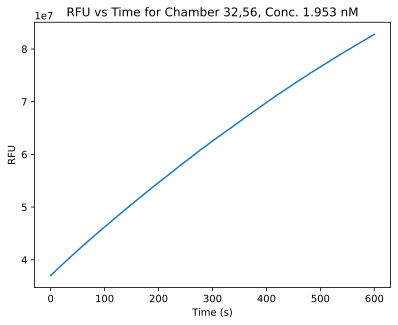

In [39]:
import matplotlib.pyplot as plt

# Let's plot one well, at one concentration:
desired_concentration = 1.953 #nM
desired_chamber = '32,56'

# Shorthands:
c = kinetics_data['indep_vars']['concentration']
t = kinetics_data['indep_vars']['time']
chamber_ids = kinetics_data['indep_vars']['chamber_IDs']
l = kinetics_data['dep_vars']['luminance']

time_values_for_conc = t[c == desired_concentration][0]
RFU_for_conc_and_chamber = l[c == desired_concentration, :, chamber_ids == desired_chamber][0]

plt.plot(time_values_for_conc, RFU_for_conc_and_chamber)
plt.xlabel('Time (s)')
plt.ylabel('RFU')
plt.title(f'RFU vs Time for Chamber {desired_chamber}, Conc. {desired_concentration} nM')


Text(0.5, 1.0, 'RFU vs Time for Chamber 32,56')

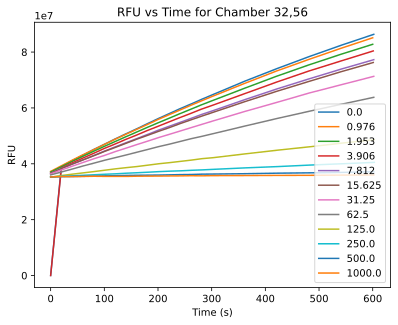

In [26]:
import numpy as np
plt.xlabel('Time (s)')
plt.ylabel('RFU')

# Let's plot one well at all concentrations:
plt.plot(t.T, np.squeeze(l[:, :, chamber_ids == desired_chamber]).T)
plt.legend(c)
plt.xlabel('Time (s)')
plt.ylabel('RFU')
plt.title(f'RFU vs Time for Chamber {desired_chamber}')

Text(0.5, 1.0, 'RFU vs Chamber ID for Concentration 31.25 nM')

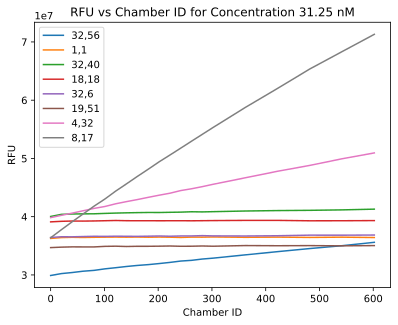

In [27]:
# Now let's plot many wells at one concentration:
desired_concentration = 31.25 #nM
desired_chambers = ['32,56', '1,1', '32,40', '18,18', '32,6', '19,51', '4,32', '8,17']

time_values_for_conc = t[c == desired_concentration][0]
RFU_for_conc_and_chambers = l[c == desired_concentration, :, np.isin(chamber_ids, desired_chambers)]

plt.plot(time_values_for_conc.T, np.squeeze(RFU_for_conc_and_chambers).T)
plt.legend(desired_chambers)
plt.xlabel('Chamber ID')
plt.ylabel('RFU')
plt.title(f'RFU vs Chamber ID for Concentration {desired_concentration} nM')

# Line fitting is very fast

In [34]:
import time

import numpy as np
from sklearn.linear_model import LinearRegression

start = time.time()
RFU_for_fitting = l[:, 1:5, :]  # skip the first couple points, because we get weird values
time_array_for_fitting = t[:, 1:5]  # skip the first couple points, because we get weird values

n_conc, n_time, n_chamb = RFU_for_fitting.shape  # (C, T, K)
model = LinearRegression()

intercept = np.full((n_conc, n_chamb), np.nan)   # pre-fill with nan
slope     = np.full_like(intercept, np.nan)

for i in range(n_conc):
    Xi = time_array_for_fitting[i].reshape(-1, 1)          # (Ti, 1)
    yi = RFU_for_fitting[i]                          # (Ti, K)

    # 1. keep chambers that have *no* NaNs over time
    good_chamb = ~np.isnan(yi).any(axis=0)     # (K,) boolean mask
    if not good_chamb.any():                   # nothing left to fit
        continue

    y_good = yi[:, good_chamb]                 # (Ti, K_good)

    # 2. (optional) drop time points that are still NaN in *any* kept chamber
    good_rows = ~np.isnan(y_good).any(axis=1)  # (Ti,) mask
    Xi_c, y_good_c = Xi[good_rows], y_good[good_rows]

    if len(Xi_c) < 2:                          # need ≥2 points for a line
        continue

    # 3. multi-output linear regression
    model.fit(Xi_c, y_good_c)
    intercept[i, good_chamb] = model.intercept_      # (K_good,)
    slope[i,     good_chamb] = model.coef_[:, 0]     # (K_good,)

elapsed = time.time() - start
print(f'Fit slopes for {len(chamber_ids)} wells at {len(c)} concentrations.')
print('Elapsed', np.round(elapsed, 3), 'seconds.')

Fit slopes for 1792 wells at 12 concentrations.
Elapsed 0.017 seconds.


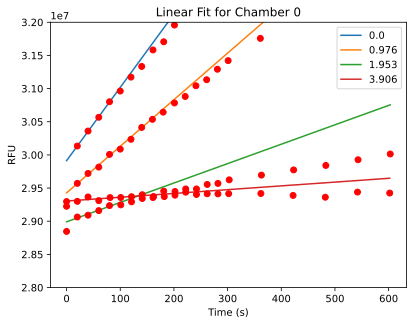

In [38]:
concentration_indices = np.array([0,5,8, 10])

# Plot the lines for chamber 0, first four concentrations, using slope and intercept:
plt.plot(t[concentration_indices].T, slope[concentration_indices, 5] * t[concentration_indices].T + intercept[concentration_indices, 5]) 
plt.ylim(2.8e7, 3.2e7)
plt.xlabel('Time (s)')
plt.ylabel('RFU')
plt.title('Linear Fit for Chamber 0')
plt.legend(c)

# Then also plot the experimental data for the same chamber and concentrations:
plt.plot(t[concentration_indices].T, l[concentration_indices, :, 5].T, 'ro')  # make the points red:

plt.show()

# Product Standard

Text(0.5, 1.0, 'Conc vs RFU for Chamber 32,56')

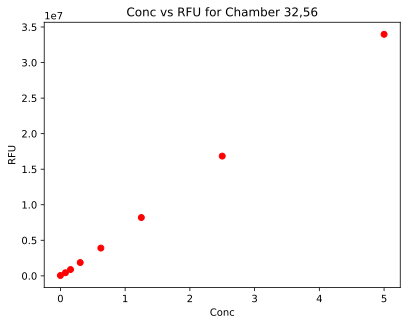

In [44]:
import numpy as np

# Shorthands:
c_std = standard_data['indep_vars']['concentration']
t_std = standard_data['indep_vars']['time']
chamber_ids_std = standard_data['indep_vars']['chamber_IDs']
l_std = standard_data['dep_vars']['luminance']

desired_chamber = '32,56'

# Let's plot one well at all concentrations:
plt.plot(c_std.T, np.squeeze(l_std[:, :, chamber_ids_std == desired_chamber]).T, 'ro')
#plt.legend(c_standard)
plt.xlabel('Conc')
plt.ylabel('RFU')
plt.title(f'Conc vs RFU for Chamber {desired_chamber}')

In [ ]:
import time

import numpy as np
from sklearn.linear_model import LinearRegression

start = time.time()
RFU_for_fitting = l_std[:, :, :]  # skip the first couple points, because we get weird values
conc_array_for_fitting = c_std[:]  # skip the first couple points, because we get weird values

n_conc, n_time, n_chamb = RFU_for_fitting.shape  # (C, T, K)
model = LinearRegression()

intercept = np.full((n_chamb), np.nan)   # pre-fill with nan
slope     = np.full_like(intercept, np.nan)

Xi = conc_array_for_fitting[i].reshape(-1, 1)          # (Ti, 1)
yi = RFU_for_fitting[i]                          # (Ti, K)

# 1. keep chambers that have *no* NaNs over time
good_chamb = ~np.isnan(yi).any(axis=0)     # (K,) boolean mask
if not good_chamb.any():                   # nothing left to fit
    continue

y_good = yi[:, good_chamb]                 # (Ti, K_good)

# 2. (optional) drop time points that are still NaN in *any* kept chamber
good_rows = ~np.isnan(y_good).any(axis=1)  # (Ti,) mask
Xi_c, y_good_c = Xi[good_rows], y_good[good_rows]

if len(Xi_c) < 2:                          # need ≥2 points for a line
    continue

# 3. multi-output linear regression
model.fit(Xi_c, y_good_c)
intercept[i, good_chamb] = model.intercept_      # (K_good,)
slope[i,     good_chamb] = model.coef_[:, 0]     # (K_good,)

elapsed = time.time() - start
print(f'Fit slopes for {len(chamber_ids)} wells at {len(c)} concentrations.')
print('Elapsed', np.round(elapsed, 3), 'seconds.')

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# ---- (Use the final RFU (probably, only RFU) for fitting standard) ----
RFU_by_conc_chamb = l_std[:, -1, :]        # shape (n_conc , n_chamb)

n_conc, n_chamb = RFU_by_conc_chamb.shape
concs = c_std[:]                 # 1-D vector of concentrations
X_all = concs.reshape(-1, 1)                         # (n_conc , 1)

slope     = np.full(n_chamb, np.nan)
intercept = np.full_like(slope, np.nan)

for j in range(n_chamb):
    y = RFU_by_conc_chamb[:, j]                      # (n_conc,)
    good = ~np.isnan(y) & ~np.isnan(concs)           # per-chamber mask

    # need at least two distinct concentration points
    if good.sum() < 2 or np.unique(concs[good]).size < 2:
        continue

    model.fit(X_all[good], y[good])
    intercept[j] = model.intercept_
    slope[j]     = model.coef_[0]

print(f"Fit standard curves for {np.count_nonzero(~np.isnan(slope))}"
      f" of {n_chamb} chambers.")


Fit standard curves for 1792 of 1792 chambers.


[-176987.40603821]


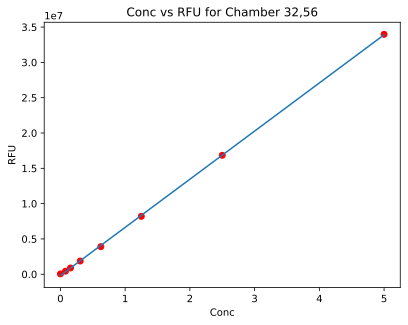

In [65]:
import numpy as np

# Shorthands:
c_std = standard_data['indep_vars']['concentration']
t_std = standard_data['indep_vars']['time']
chamber_ids_std = standard_data['indep_vars']['chamber_IDs']
l_std = standard_data['dep_vars']['luminance']

desired_chamber = '32,56'

# Let's plot one well at all concentrations:
plt.plot(c_std.T, np.squeeze(l_std[:, :, chamber_ids_std == desired_chamber]).T, 'ro')
#plt.legend(c_standard)
plt.xlabel('Conc')
plt.ylabel('RFU')
plt.title(f'Conc vs RFU for Chamber {desired_chamber}')

# Also plot the line fit:
#print(slope[chamber_ids_std == desired_chamber].shape)
print(intercept[chamber_ids_std == desired_chamber])
plt.plot(c_std[:].T, slope[chamber_ids_std == desired_chamber][0] * c_std[:].T + intercept[chamber_ids_std == desired_chamber])

In [ ]:
import numpy as np
from scipy import sparse
from sklearn.linear_model import LinearRegression
import time

### The following method is faster, but less intuitive to me.

start = time.time()

# -----------------------------------------------------------------
# 0.  Inputs  (same as before)
# -----------------------------------------------------------------
concs = c_std[:]                     # shape (n_conc,)                – product concentrations
y2D   = l_std[:, -1, :]              # shape (n_conc , n_chamb)       – final-time RFU
n_conc, n_chamb = y2D.shape

# -----------------------------------------------------------------
# 1.  “Long” vectors: one row per (conc , chamber) pair
# -----------------------------------------------------------------
y      = y2D.ravel()                                 # (n_conc * n_chamb,)
conc_v = np.repeat(concs, n_chamb)                   # same length
chamb_v= np.tile(np.arange(n_chamb), n_conc)         # same length

# keep only rows whose target is not NaN
good   = ~np.isnan(y)
y, conc_v, chamb_v = y[good], conc_v[good], chamb_v[good]

# -----------------------------------------------------------------
# 2.  Sparse design matrix:  [ intercept_cols | slope_cols ]
# -----------------------------------------------------------------
rows = np.arange(len(y))

# intercept block: 1 where row belongs to chamber j
X_inter = sparse.csr_matrix((np.ones_like(rows),
                             (rows, chamb_v)),
                            shape=(len(y), n_chamb))

# slope block: concentration value where row belongs to chamber j
X_slope = X_inter.multiply(conc_v[:, None])          # element-wise

X = sparse.hstack([X_inter, X_slope], format='csr')  # shape (N , 2*n_chamb)

# -----------------------------------------------------------------
# 3.  One multi-output linear regression
# -----------------------------------------------------------------
model = LinearRegression(fit_intercept=False)        # intercept already in X
model.fit(X, y)

coef = model.coef_                                   #  length 2*n_chamb
intercept = coef[:n_chamb]
slope     = coef[n_chamb:]

# -----------------------------------------------------------------
# 4.  Mark chambers with <2 distinct concentration points as NaN
# -----------------------------------------------------------------
n_valid   = np.array([(~np.isnan(y2D[:, j])).sum() for j in range(n_chamb)])
uniq_conc = np.array([np.unique(concs[~np.isnan(y2D[:, j])]).size
                      for j in range(n_chamb)])
bad = (n_valid < 2) | (uniq_conc < 2)

intercept[bad] = np.nan
slope[bad]     = np.nan

print(f"Fit standard curves for {(~bad).sum()} of {n_chamb} chambers.")

elapsed = time.time() - start

print('Elapsed', np.round(elapsed, 3), 'seconds.')

Fit standard curves for 1792 of 1792 chambers.
Fit slopes for 1792 wells.
Elapsed 0.062 seconds.


In [64]:
print(intercept)
print(slope)

[-167799.0494886  -203599.43961128 -222791.89024465 ... -209480.85796129
 -201517.64184339 -176987.40603821]
[6175691.93257026 6488772.89229004 6888963.96979006 ... 8293430.44148004
 7871993.458114   6816451.04177155]


## 2. Standards

In [3]:
htbam_experiment.fit_standard_curve('standard_0')

Existing run data not found. Fetching from database.
Standard curve data found for run "standard_0" with:
	-- 1 time points.
	-- 1792 chambers.
	-- 8 concentrations.

Fitting standard curve...


100%|██████████| 1792/1792 [00:00<00:00, 12647.09it/s]


In [4]:
htbam_experiment.plot_standard_curve_chip('standard_0', egfp_conc_units=EGFP_SLOPE_CONC_UNITS)

## 3. Fit Initial Rates

In [24]:
htbam_experiment.fit_initial_rates('kinetic_0', 
                                   'standard_0',
                                   max_rxn_perc=10,
                                   starting_timepoint_index=1,
                                   max_rxn_time=150,
                                   substrate_conc=60 # Only specified if you have a fixed substrate concentration
                                   )



Existing run data not found. Fetching from database.
Activity data found for run "kinetic_0" with:
	-- 21 time points.
	-- 1792 chambers.
	-- 12 concentrations.
Using standard curve data from run "standard_0" to convert luminance data to concentration data.


100%|██████████| 1792/1792 [00:12<00:00, 141.44it/s]

12 reactions had less than 2 points for fitting


In [9]:
print(htbam_experiment._db_conn)

chamber_metadata: 
	1,1: 
		id: WT
		x_center_chamber: 45
		y_center_chamber: 55
		radius_chamber: 34
		xslice: (404, 504)
		yslice: (374, 474)
	1,2: 
		id: S081T
		x_center_chamber: 47
		y_center_chamber: 55
		radius_chamber: 34
		xslice: (519, 619)
		yslice: (374, 474)
	1,3: 
		id: L50F/E166V
		x_center_chamber: 51
		y_center_chamber: 55
		radius_chamber: 36
		xslice: (634, 734)
		yslice: (374, 474)
	1,4: 
		id: R060T
		x_center_chamber: 51
		y_center_chamber: 53
		radius_chamber: 34
		xslice: (750, 850)
		yslice: (374, 474)
	1,5: 
		id: F008Q
		x_center_chamber: 53
		y_center_chamber: 53
		radius_chamber: 34
		xslice: (865, 965)
		yslice: (374, 474)
	1,6: 
		id: I106L
		x_center_chamber: 55
		y_center_chamber: 53
		radius_chamber: 34
		xslice: (980, 1080)
		yslice: (374, 474)
	...
runs: 
	standard_0: 
		name: 5-FAM
		substrate: 5-FAM
		conc_unit: uM
		assays: 
			0: 
				conc: 0.0
				time_s: [0]
				chambers: 
					1,1: 
						sum_chamber: [180011]
						std_chamber: [56]
					1,10

In [28]:
initial_rates_dict = htbam_experiment._db_conn.get_analysis('kinetic_0', 'linear_regression', 'slopes')

In [27]:
htbam_experiment.plot_initial_rates_chip('kinetic_0', time_to_plot=1)

## 4. Filter initial rates

In [ ]:
htbam_experiment.compute_enzyme_concentration('kinetic_0', EGFP_SLOPE)

In [ ]:
htbam_experiment.filter_initial_rates('kinetic_0',
                                      'standard_0',
                                      standard_curve_r2_cutoff = 0.98,
                                      expression_threshold = 1.0,
                                      initial_rate_R2_threshold = 0.0, 
                                      positive_initial_slope_filter = False)

In [ ]:
htbam_experiment.plot_filtered_initial_rates_chip('kinetic_0')

## 5. Fit Inhibition Constant:

In [ ]:
# NOTE: This will matter for michaelis-menten, but I am leaving it for now to fit IC50s
# substrate_conc_unit = db_conn._json_dict['runs']['kinetics_0']['conc_unit']
# if  substrate_conc_unit != EGFP_SLOPE_CONC_UNITS: print('Substrate concentration units do not match EGFP standard curve units! \n{} != {}'.format(substrate_conc_unit, EGFP_SLOPE_CONC_UNITS))

# unit_converstion = 0.001 #convert FROM eGFP units TO substrate units (in this case, nM to uM)
# enzyme_concentration_converted_units = enzyme_concentration * unit_converstion

# #Double check!
# print('Conversion:')
# print('{} {} = {} {}  ?'.format(enzyme_concentration[0], EGFP_SLOPE_CONC_UNITS, enzyme_concentration_converted_units[0], substrate_conc_unit))

In [ ]:
htbam_experiment.fit_ic50s('kinetic_0')

In [ ]:
htbam_experiment.filter_ic50s('kinetic_0',
                              z_score_threshold_ic50 = 1.5,
                              z_score_threshold_expression = 1.5,
                               save_intermediate_data = False)

In [ ]:
htbam_experiment.plot_filtered_ic50('kinetic_0', show_average_fit=True)

## 6. Export to CSV

In [ ]:
htbam_experiment.export_ic50_result_csv(path_to_save=root,
                                        run_name='kinetics_0')